In [22]:
from __future__ import division, print_function
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from importlib import reload  # Python 3
import utils; reload(utils)
from utils import plots

from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D  # Conv2D: Keras2
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image



%matplotlib inline

# Define constants and hyperparameters

In [2]:
path='C:\\Users\\U5752631\Desktop\\csproj17s2\\artefacts\\preprocessing\\create training and test datasets\\PKlot\\'
model_path = 'C:\\Users\\U5752631\\Desktop\\csproj17s2\\artefacts\\data\\pretrained_models\\vgg16.h5'
model_name='vgg16.h5'
results_path='C:\\Users\\U5752631\\Desktop\\csproj17s2\\artefacts\\data\\pretrained_models\\vgg16\\'
#adjust according to memory avilible
batch_size = 16

In [3]:
# Mean of each channel as provided by VGG researchers and change rgb axis
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

In [4]:
# convolutional block definition
def ConvBlock(model,layers,  filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Conv2D(filters, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

#fully-connected block definition
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [5]:
#VGG model architecture 
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(model, 2, 64)
    ConvBlock(model, 2, 128)
    ConvBlock(model, 3, 256)
    ConvBlock(model, 3, 512)
    ConvBlock(model, 3, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(2, activation='softmax'))
    return model

In [6]:
model = VGG_16()

C:\ProgramData\Anaconda3\lib\site-packages\keras\layers\core.py:629: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [7]:
#load orignal weights
model.load_weights(get_file(model_name, model_path, cache_subdir='models'))

In [14]:
#laod fine tuned weights 
model.load_weights(results_path+'parkinglot_vgg16.h5')

In [10]:
#helper functions
def get_batches( path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=8, class_mode='categorical'):
    return gen.flow_from_directory(path, target_size=(224,224),
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [11]:
train_batches = get_batches(path+'train', batch_size=batch_size)
validation_batches = get_batches(path+'valid', batch_size=batch_size*2)

Found 61749 images belonging to 2 classes.
Found 8779 images belonging to 2 classes.


In [12]:
#fine tune
lr=0.001
batches=train_batches

model.pop()
for layer in model.layers: layer.trainable=False
model.add(Dense(batches.num_class, activation='softmax'))
model.compile(optimizer=Adam(lr=lr),loss='categorical_crossentropy', metrics=['accuracy'])

classes = list(iter(batches.class_indices))
for c in batches.class_indices:
    classes[batches.class_indices[c]] = c
    
model.finetune(train_batches)

In [13]:
#fit
nb_epoch=1
model.model.optimizer.lr=0.01
model.fit_generator(batches, steps_per_epoch=int(np.ceil(batches.samples/batch_size)),
                    epochs=nb_epoch,validation_data=validation_batches, validation_steps=int(np.ceil(validation_batches.samples/batch_size)))

Epoch 1/1
3860/3860 [==============================] - 3015s - loss: 0.0589 - acc: 0.9827 - val_loss: 0.0202 - val_acc: 0.9949


In [ ]:
model.save_weights(results_path+'parkinglot_vgg16.h5')

In [13]:
model.load_weights(results_path+'parkinglot_vgg16.h5')

In [ ]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
model.optimizer.lr = 0.11
no_of_epochs=2
batch_size = 16
for epoch in range(no_of_epochs):
    print("Running epoch: %d" % epoch)
    
    model.fit_generator(batches, steps_per_epoch=int(np.ceil(batches.samples/batch_size)),                    
                        epochs=nb_epoch,validation_data=validation_batches, validation_steps=int(np.ceil(validation_batches.samples/batch_size)))

    
    latest_weights_filename = 'ft%d.h5' % epoch
    model.save_weights(results_path+latest_weights_filename)
print("Completed %s fit operations" % no_of_epochs)

Found 61749 images belonging to 2 classes.


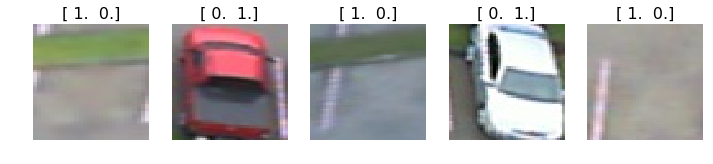

In [16]:
#sample batch data
batch_size = 5
batches = get_batches(path+'train', batch_size=batch_size)
imgs,labels = next(batches)
plots(imgs, titles=labels)

In [17]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('Classes: {}'.format(classes[:5]))
    print('Probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [18]:
pred_batch(imgs)

Shape: (5, 2)
Classes: ['Empty', 'Occupied']
Probabilities: [  1.0000e+00   6.3662e-11]

Predictions prob/class: 
  1.0000/Empty
  1.0000/Occupied
  1.0000/Empty
  1.0000/Occupied
  1.0000/Empty


In [20]:
batch_size=16
#get the test batches and remove class label
test_batches = get_batches(path+'test', shuffle=False, batch_size=batch_size, class_mode=None)
#generate the probobailty of belonging to a class
val_batches, probs = test_batches, model.predict_generator(test_batches, int(np.ceil(test_batches.samples/batch_size)))

Found 16966 images belonging to 2 classes.


[[7455 1203]
 [  45 8263]]


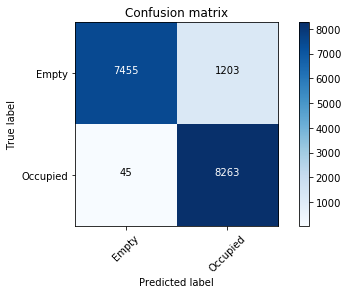

In [21]:
#computing confustion matrix

our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

expected_labels = val_batches.classes

cm = confusion_matrix(expected_labels, our_labels)
plot_confusion_matrix(cm, val_batches.class_indices)

In [23]:
#weight paths
'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5'
'https://github.com/fchollet/deep-learning-models/releases/download/v0.4/xception_weights_tf_dim_ordering_tf_kernels.h5'
'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
#Inception-v4
'https://github.com/fchollet/deep-learning-models/releases/download/v0.7/'
'https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels.h5'

'https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels.h5'

# References

In [ ]:
papr vgg
caffe model zoo
fast ai course
standford ai course